In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset
file_path = "/content/Merged_Disasters(2).csv"  # Update the path if needed
df = pd.read_csv(file_path)

# Perform stratified splitting (70% Train, 15% Validation, 15% Test)
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df["Binary_class"], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df["Binary_class"], random_state=42)

# Save the split datasets
train_df.to_csv("train_data.csv", index=False)
val_df.to_csv("val_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

# Create a structured summary table
split_summary = pd.DataFrame({
    "Train (70%)": train_df["Binary_class"].value_counts(),
    "Validation (15%)": val_df["Binary_class"].value_counts(),
    "Test (15%)": test_df["Binary_class"].value_counts(),
    "Total": df["Binary_class"].value_counts()
}).T

# Save the summary table
split_summary.to_csv("split_summary.csv")

# Display summary
print("\nData Split Summary:\n", split_summary)
print("\nData split completed and saved as CSV files.")


Data Split Summary:
 Binary_class      Non-Damage  Damage
Train (70%)            10853    1804
Validation (15%)        2326     386
Test (15%)              2326     387
Total                  15505    2577

Data split completed and saved as CSV files.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
340/340 - 140s - 412ms/step - accuracy: 0.5450 - loss: 0.7944
Epoch 2/10
340/340 - 137s - 403ms/step - accuracy: 0.5725 - loss: 0.6913
Epoch 3/10
340/340 - 137s - 403ms/step - accuracy: 0.5856 - loss: 0.6864
Epoch 4/10
340/340 - 137s - 403ms/step - accuracy: 0.5874 - loss: 0.6820
Epoch 5/10
340/340 - 136s - 401ms/step - accuracy: 0.5936 - loss: 0.6796
Epoch 6/10
340/340 - 137s - 402ms/step - accuracy: 0.5898 - loss: 0.6785
Epoch 7/10
340/340 - 137s - 402ms/step - accuracy: 0.5906 - loss: 0.6763
Epoch 8/10
340/340 - 136s - 401ms/step - accuracy: 0.5886 - loss: 0.6775
Epoch 9/10
340/340 - 137s - 403ms/step - accuracy: 0.5926 - loss: 0.6742
Epoch 10/10
340/340 - 137s - 403ms/step - accuracy: 0.5944 - loss: 0.6733
679/679 ━━━━━━━━━━━━━━━━━━━━ 47s 70ms/step
679/679 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step
Training Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.65      0.63     10853
           1       0.62      0.57      0.

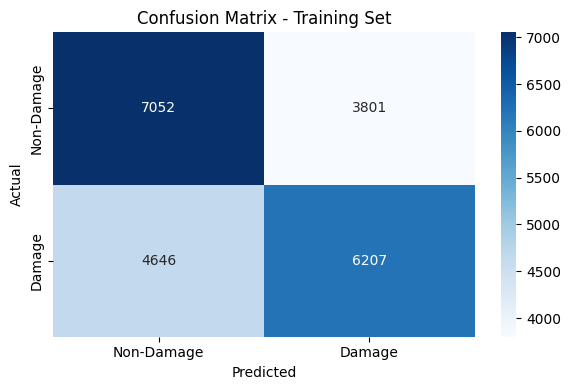

In [ ]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Load Data
train_df = pd.read_csv("/content/train_data.csv")
val_df = pd.read_csv("/content/val_data.csv")
test_df = pd.read_csv("/content/test_data.csv")

# Standardize labels
label_map = {'damage': 1, 'non-damage': 0}
for df in [train_df, val_df, test_df]:
    df['Binary_class'] = df['Binary_class'].str.strip().str.lower().map(label_map)
    df['Processed_data'] = df['Processed_data'].fillna("")

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english', ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df['Processed_data'])
y_train = train_df['Binary_class'].values

# Apply SMOTE
smote = SMOTE(sampling_strategy=1, k_neighbors=3, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Reshape for CNN
X_train_smote_cnn = X_train_smote.toarray().reshape(X_train_smote.shape[0], X_train_smote.shape[1], 1)

# Build CNN Model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu',
                 input_shape=(X_train_smote_cnn.shape[1], 1),
                 kernel_regularizer=l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
early_stop = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
model.fit(X_train_smote_cnn, y_train_smote,
          epochs=10,
          batch_size=64,
          callbacks=[early_stop],
          class_weight={0: 1, 1: 1},
          verbose=2)

# Predict on Train Set
y_train_pred = (model.predict(X_train_smote_cnn) > 0.5).astype(int)
y_train_proba = model.predict(X_train_smote_cnn)

# Training Metrics
print("Training Classification Report:\n", classification_report(y_train_smote, y_train_pred))
print("Training Accuracy:", accuracy_score(y_train_smote, y_train_pred))
print("Training ROC-AUC:", roc_auc_score(y_train_smote, y_train_proba))

# Confusion Matrix
cm_train = confusion_matrix(y_train_smote, y_train_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Damage', 'Damage'], yticklabels=['Non-Damage', 'Damage'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Training Set")
plt.tight_layout()
plt.show()
